In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import statsmodels.api as sm

from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor

def importances_to_dict(importance_df: pd.DataFrame) -> dict:
    return dict(zip(importance_df["Feature"], importance_df["Importance"]))


In [83]:
# Load feature dictionary
dict_path = r"C:\Users\Sergey Filipov\Desktop\Лятно училище\Кейс SHARE\PyCharm\significant_features_summary - dictionary.xlsx"
dict_df = pd.read_excel(dict_path, sheet_name="dictionary")
feature_desc_map = dict(zip(dict_df["Variable"], dict_df["Short label with interpretation"]))

def get_feature_label(code):
    """
    Returns the human-readable description for a given feature code.
    If the code is not found in the dictionary, returns the code itself.
    """
    return feature_desc_map.get(code, code)

def wrap_label_words(text, words_per_line=4):
    """
    Breaks label text into multiple lines with up to `words_per_line` words per line.
    Useful for improving readability of long labels in plots.
    """
    words = str(text).split()
    return '\n'.join(
        [' '.join(words[i:i+words_per_line]) for i in range(0, len(words), words_per_line)]
    )


In [85]:
def process_chunk(
    part: int,
    file_path=r"C:\Users\Sergey Filipov\Desktop\Лятно училище\Кейс SHARE\PyCharm\statisticsexp.csv",
    sep=';',
    low_memory=False,
    target="age2020",
    exclude=None,
    exclude_vif=None
):
 
    """
    This list contains columns that have a direct or indirect causal relationship with the target variable.
    Including these columns would result in data leakage, leading to unrealistically high model performance.
    These columns are excluded from the feature set to ensure a valid modeling process.
    """
    if exclude is None:
        exclude = [
            "age2020", "hhid8", "year_2", "ch_yrbirth_4", "year_1", "ch_yrbirth_3", "ch_move_out_year_2",
            "ch_move_out_year_1", "mergeid", "ch_yrbirth_2", "yrbirthp", "mobirthp", "coupleid8", "ch020_4",
            "yrbirth", "mobirth", "age_int", "year_mean", "year_1", "ch_yrbirth_1", "sn027_2", "prx_mean",
            "yrbirthp", "mobirthp", "mergeidp8", "rel_mergeid8_1", "rel_mergeid8_2", "sn027_1", "ch505_3",
            "rel_mergeid8_3", "rel_mergeid8_4", "rel_mergeid8_5", "rel_mergeid8_6", "rel_mergeid8_7", "prx_2",
            "rel_mergeid8_8", "rel_mergeid8_9", "rel_mergeid8_10", "rel_mergeid8_11", "dn002_", "panel_change_size",
            "hhid8", "coupleid8", "householdid", "relationtype", "rel_", "rel_mergeid", "mergeidp8_update_ca",
            "int_month", "int_year", "move_out_year_1", "move_out_year_2", "move_out_year_3", "ep329_", "sn005a_1",
            "move_out_year_4", "move_out_year_5", "move_out_year_6", "move_out_year_7", "move_out_year_8",
            "move_out_year_9", "move_out_year_10", "move_out_year_11", "move_out_year_12", "move_out_year_13",
            "move_out_year_14", "move_out_year_15", "move_out_year_16", "move_out_year_17", "move_out_year_18",
            "move_out_year_19", "move_out_year_20", "ch_yrbirth_youngest_child_1", "ch_yrbirth_youngest_child_2",
            "ch_yrbirth_youngest_child_3", "ch_yrbirth_youngest_child_4", "ch_yrbirth_youngest_child_5", "ch505_2",
            "GGIR_1675_1700_ENMO_total", "ch_yrbirth_youngest_child_6", "ch_yrbirth_youngest_child_7", "int_month_ca",
            "ch_yrbirth_youngest_child_9", "ch_yrbirth_youngest_child_10", "ch_yrbirth_youngest_child_11",
            "ch_yrbirth_youngest_child_12", "ch_yrbirth_youngest_child_13", "ch_yrbirth_youngest_child_14",
            "ch_yrbirth_youngest_child_15", "ch_yrbirth_youngest_child_16", "ch_yrbirth_youngest_child_17",
            "ch_yrbirth_youngest_child_18", "ch_yrbirth_youngest_child_19", "ch_yrbirth_youngest_child_20",
            "interview", "ch_yrbirth_youngest_child_8", "ch006_1", "ch006_2", "ch006_4", "ch006_5",
            "ch006_6", "ch006_7", "ch006_8", "ch006_9", "ch006_10", "ch006_11", "ch006_12", "ch006_13", "ch006_14",
            "ch006_16", "ch006_17", "ch006_19", "ch006_20", "ch020_3", "ch020_2", "ch020_1", "dn003_",
            "ch_gender_4",
        ]

    """
    This list contains columns with high multicollinearity, identified by a Variance Inflation Factor (VIF) above 10.
    VIF quantifies how much a feature is explained by the other features. High VIF means redundant information and unstable model coefficients.
    Removing these features helps improve model stability and interpretability.
    """
    if exclude_vif is None:
        exclude_vif = [
            "dn042_", "coupleid8_update_ca", "ch303d2", "ch303d1", "ft002_", "ch018d13_1",
            "ch018d9_1", "ch018d10_2", "ft025_", "ch018d10_1", "ch018d4_2", "ch018d4_1",
            "co209_", "country", "ch018d8_2", "ft015_", "sn_satisfaction", "ch018d7_1",
            "ch018d5_2", "ch018d6_1", "ch018d6_3", "ch018d6_2", "co010_", "sn009_1",
            "ch018d8_1", "ch102_3", "ch302_", "br623_", "ac016_", "agep2020",
            "ch014_2", "ac023_", "ch014_1", "ch102_2", "ac018_", "ex110_",
            "ac015_", "ac025_", "cf008tot", "ac022_", "ac020_", "ch102_1",
            "ac014_", "ch_gender_1", "ac019_", "ac024_", "ch_gender_2", "te050_",
            "ch103_2", "co206_", "ac017_", "ch_gender_3", "gender", "br015_",
            "bfi10_consc", "ep064d1", "ch018d5_1", "dn027_1", "ac021_", "ac012_",
            "ch006_2", "close_mean", "ch103_3", "ch_fin_gave_1", "ch018d7_2", "br016_",
            "bfi10_agree", "ex802_", "language", "ex026_", "casp", "ch_relation_2",
            "co007_", "dn127_2", "ep097_", "ch103_1", "ep671d2", "ex009age"
        ]

    df = pd.read_csv(file_path, sep=sep, low_memory=low_memory)
    all_exclude = [col for col in (exclude or []) + (exclude_vif or []) if col != target]
    df = df.drop(columns=[col for col in all_exclude if col in df.columns])

    """
    Replace all negative values with np.nan in numeric columns only.
    Negative values are considered invalid for this dataset.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        df[col] = df[col].map(lambda x: np.nan if pd.notnull(x) and x < 0 else x)

    """
    Drop columns with at least 70% missing values (keep columns with 30% or more valid data).
    This prevents inclusion of features that are mostly missing.
    """
    min_non_na = int(len(df) * 0.3)
    df = df.dropna(axis=1, thresh=min_non_na)

    """
    Impute remaining missing values in numeric columns with the median.
    Median imputation is robust to outliers and is a common method for survey data.
    The median is preferred over the mean because it is not affected by extreme values (outliers),
    which can skew the average. Unlike the mode, which is more appropriate for categorical variables,
    the median provides a stable and representative value for numeric features that may not have a dominant value.
    """
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    df = df[df[target].notnull()].copy()

    """
    Encode the target variable using label encoding (integer encoding).
    This prepares the target for classification models.
    """
    y = LabelEncoder().fit_transform(df[target].astype(str))

    """
    FEATURE CHUNKING:
    The features (excluding the target) are split into 10 chunks of (approximately) equal size.
    This allows iterative or parallel processing of feature subsets.
    """
    feature_cols = [col for col in df.columns if col != target]
    if len(feature_cols) == 0:
        print("No features left after exclusions!")
        return pd.DataFrame({"Feature": [], "Importance": []})

    chunk_size = len(feature_cols) // 10
    feature_chunks = [feature_cols[i:i + chunk_size] for i in range(0, len(feature_cols), chunk_size)]
    if len(feature_chunks) > 10:
        feature_chunks[9].extend(feature_chunks.pop())

    this_chunk = feature_chunks[part]
    X_chunk = df[this_chunk].copy()

    for col in X_chunk.select_dtypes(include=["object", "category"]).columns:
        X_chunk[col] = LabelEncoder().fit_transform(X_chunk[col].astype(str))

    """
    Split the data into training and test sets (80%/20%) for model training and validation.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_chunk, y, test_size=0.2, random_state=42
    )

    """
    Train a Decision Tree Classifier to evaluate feature importance on the current chunk.
    """
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    importances = clf.feature_importances_
    importances_df = pd.DataFrame({
        "Feature": this_chunk,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    print(f"\nTop 10 features for chunk {part+1} of 10:")
    print(importances_df.head(10))

    return importances_df, df


In [87]:
all_importances = {}
all_dfs = []

for i in range(10):
    print(f"Processing chunk {i}...")
    try:
        chunk_df, processed_df = process_chunk(i)
        if chunk_df.empty or chunk_df["Importance"].sum() == 0:
            print(f"Chunk {i} has no important features. Skipping.")
            continue

        """
        Convert feature importances to a dictionary and update the cumulative importance dictionary.
        """
        chunk_dict = importances_to_dict(chunk_df)
        all_importances.update(chunk_dict)

        """
        Keep only the important features from this chunk, plus the target column.
        Make sure the columns exist in the processed DataFrame.
        """
        needed_cols = list(chunk_dict.keys()) + ["age2020"]
        needed_cols = [col for col in needed_cols if col in processed_df.columns]
        all_dfs.append(processed_df[needed_cols])

    except IndexError:
        print(f"Chunk {i} does not exist (probably not enough columns). Stopping iteration.")
        break
        
    except ValueError as ve:
        print(f"ValueError in chunk {i}: {ve}. Skipping this chunk.")
        continue
        
    except Exception as e:
        print(f"Error in chunk {i}: {e}. Skipping this chunk.")
        continue


Processing chunk 0...

Top 10 features for chunk 1 of 10:
      Feature  Importance
132    br040_    0.052686
15     ac037_    0.048681
29     as003e    0.037849
76     as051e    0.031561
124    br003_    0.031210
129    br006_    0.030281
28     exrate    0.024782
13    ac036_9    0.023882
130    br033_    0.021875
14   ac036_10    0.021498
Processing chunk 1...

Top 10 features for chunk 2 of 10:
       Feature  Importance
310     ch021_    0.152399
278    ch019_2    0.066774
279    ch019_3    0.057802
277    ch019_1    0.056199
280    ch019_4    0.036437
311     ch022_    0.027840
295    ch020_5    0.022628
10   ch018d5_3    0.020589
55   ch018d8_3    0.020505
40   ch018d7_3    0.017469
Processing chunk 2...

Top 10 features for chunk 3 of 10:
     Feature  Importance
113  ch505_5    0.072215
112  ch505_4    0.071105
114  ch505_6    0.067620
157   ch511_    0.049413
115  ch505_7    0.047293
116  ch505_8    0.047089
67   ch107_1    0.035571
117  ch505_9    0.028259
68   ch107_2    0.

In [89]:
"""
Select features by importance threshold, merge the relevant data, and export the final filtered DataFrame.
"""

# Filter features with importance > 0 and keep their columns plus the target
filtered_importances = {k: v for k, v in all_importances.items() if v > 0}
selected_columns = list(filtered_importances.keys())
selected_columns_with_target = selected_columns + ["age2020"]

target = "age2020"

# Apply a stricter threshold: keep only features with importance > 0.01
final_importances = {k: v for k, v in filtered_importances.items() if v > 0.01}
selected_columns = list(final_importances.keys())
selected_columns_with_target = selected_columns + [target]

if all_dfs:
    """
    Merge processed feature chunks, drop duplicate columns, and select only the final features.
    """
    df_full_processed = pd.concat(all_dfs, axis=1)
    df_full_processed = df_full_processed.loc[:, ~df_full_processed.columns.duplicated()]
    final_columns = [col for col in selected_columns_with_target if col in df_full_processed.columns]
    filtered_df = df_full_processed[final_columns]
else:
    filtered_df = pd.DataFrame()

"""
Export the filtered DataFrame to CSV if not empty.
"""
if filtered_df.shape[0] == 0 or filtered_df.shape[1] == 0:
    print("Warning: The filtered DataFrame is empty!")
#else:
    #output_name = "filtered_features_final.csv"
    #filtered_df.to_csv(output_name, sep=';', index=False)
    #print(f"\nCSV with selected features (importance > 0.01) saved as {output_name} "
          #f"(rows: {filtered_df.shape[0]}, columns: {filtered_df.shape[1]})")


In [91]:
print("Shape:", filtered_df.shape)

Shape: (46733, 198)


In [93]:
# Target and features
y = filtered_df["age2020"].astype(float)
X = filtered_df.drop("age2020", axis=1)

# Encode categorical features (if any)
cat_cols = X.select_dtypes(include=["object", "category"]).columns
if len(cat_cols) > 0:
    for col in cat_cols:
        X[col] = X[col].astype(str).astype("category").cat.codes

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check for missing values (just in case)
if X_train.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    print("Warning: Missing values detected! Filling with median.")
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy="median")
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
else:
    print("No missing values detected. Imputation not needed.")


No missing values detected. Imputation not needed.


In [95]:
"""
Remove low-variance features and standardize the data.
"""

# Filter features with low variance
selector = VarianceThreshold(threshold=0.01)
X_train_selected = selector.fit_transform(X_train)
X_test_selected = selector.transform(X_test)
selected_columns = X_train.columns[selector.get_support()]
X_train = pd.DataFrame(X_train_selected, columns=selected_columns)
X_test = pd.DataFrame(X_test_selected, columns=selected_columns)

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)


In [97]:
"""
Train XGBoost regressor with selected hyperparameters.
"""

param_grid = {
    'colsample_bytree': 0.6,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 200,
    'subsample': 1.0,
    'min_child_weight': 3
}

model = XGBRegressor(
    **param_grid,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [99]:
"""
Evaluate the trained model on both test and train sets using MAE, MAPE, R^2, and Adjusted R^2 metrics.
"""

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# --- TEST SET EVALUATION ---
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape_val = mape(y_test, y_pred)

n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print("\n--- TEST ---")
print(f"MAE: {mae:.3f}")
print(f"MAPE: {mape_val:.2f}%")
print(f"R^2: {r2:.3f}")
print(f"Adjusted R^2: {adj_r2:.3f}")

# --- TRAIN SET EVALUATION ---
y_train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mape_train = mape(y_train, y_train_pred)

n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_train - 1)

print("\n--- TRAIN ---")
print(f"MAE: {mae_train:.3f}")
print(f"MAPE: {mape_train:.2f}%")
print(f"R^2: {r2_train:.3f}")
print(f"Adjusted R^2: {adj_r2_train:.3f}")



--- TEST ---
MAE: 2.534
MAPE: 3.62%
R^2: 0.871
Adjusted R^2: 0.868

--- TRAIN ---
MAE: 2.489
MAPE: 3.56%
R^2: 0.878
Adjusted R^2: 0.878


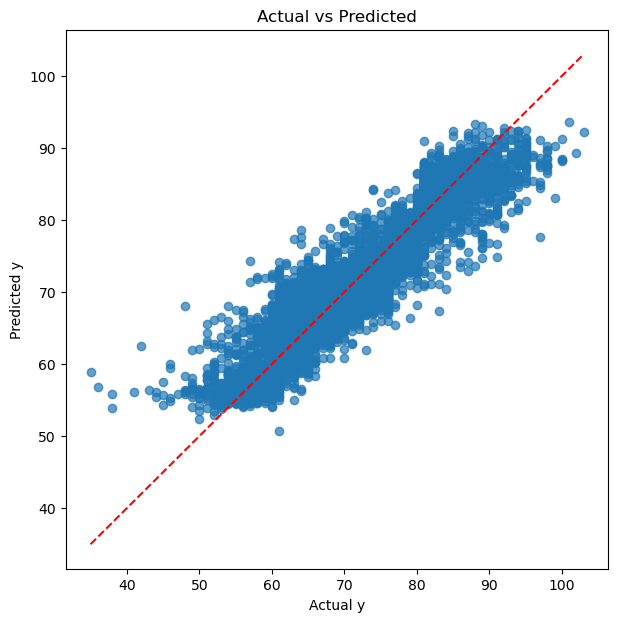

In [101]:
# --- Actual vs Predicted:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45-degree line
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Actual vs Predicted')
plt.show()


Top 20 feature importances:

Total hours worked per week: Importance 0.2060
How many months did he receive a state old-age pension?: Importance 0.1052
Unemployed since last interview: Importance 0.1023
Negative Shock: Needed to provide financial help to family members: Importance 0.0749
Chances to run out of money in the future: Importance 0.0645
For how many years have contributions been made to an old-age pension plan?: Importance 0.0584
Typical pension payment in the last year: spouse/partner survivor's pension: Importance 0.0497
Earnings employment per year after taxes: Importance 0.0425
Year last job ended: Importance 0.0417
Typical old-age pension payment for last year: Importance 0.0342
the first year of receiving a state old-age pension: Importance 0.0274
Expected age for receiving old-age pension: Importance 0.0248
Learning a list of ten words to learn and remember: Importance 0.0143
Partner outside household: Importance 0.0127
Years of contributions to the plan, public old-a

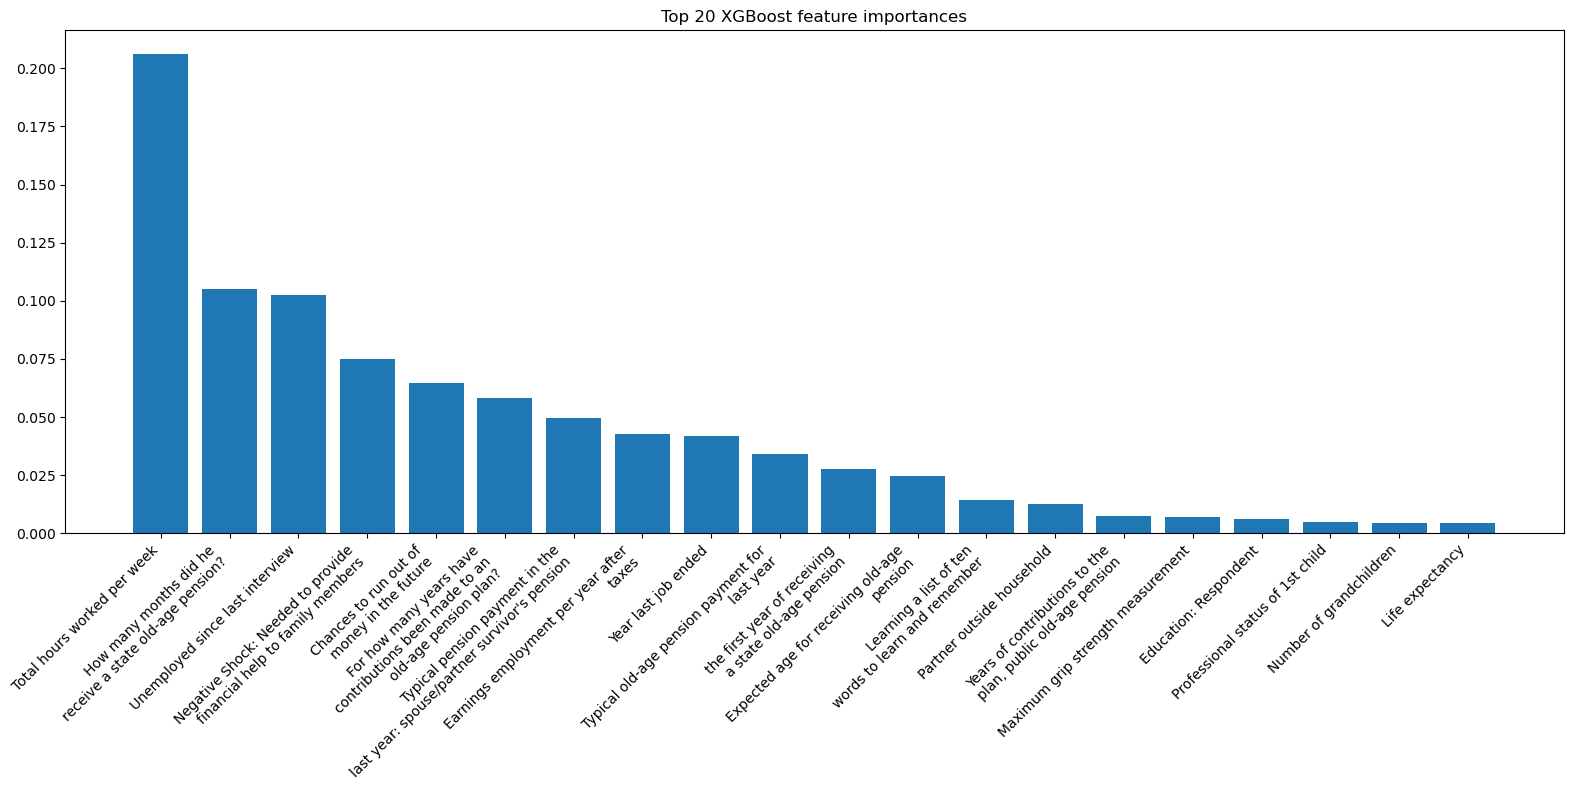

In [103]:
"""
Display and visualize the top 30 most important features according to the trained XGBoost model.
"""

importances = model.feature_importances_
top_n = 20  # Or 30
top_idx = np.argsort(importances)[::-1][:top_n]

print(f"\nTop {top_n} feature importances:")
print()

for i in top_idx:
    feature_code = X_train.columns[i]
    feature_desc = get_feature_label(feature_code)
    print(f"{feature_desc}: Importance {importances[i]:.4f}")

plt.figure(figsize=(max(14, top_n * 0.8), 8))
labels = [wrap_label_words(get_feature_label(f), words_per_line=5) for f in X_train.columns[top_idx]]

plt.bar(range(top_n), importances[top_idx])
plt.xticks(range(top_n), labels, rotation=45, ha='right', fontsize=10)
plt.title(f"Top {top_n} XGBoost feature importances")
plt.tight_layout()

plt.savefig("01_xgboost_feature_importances.png", bbox_inches='tight', dpi=200)
plt.show()


 97%|=================== | 9020/9347 [00:21<00:00]       

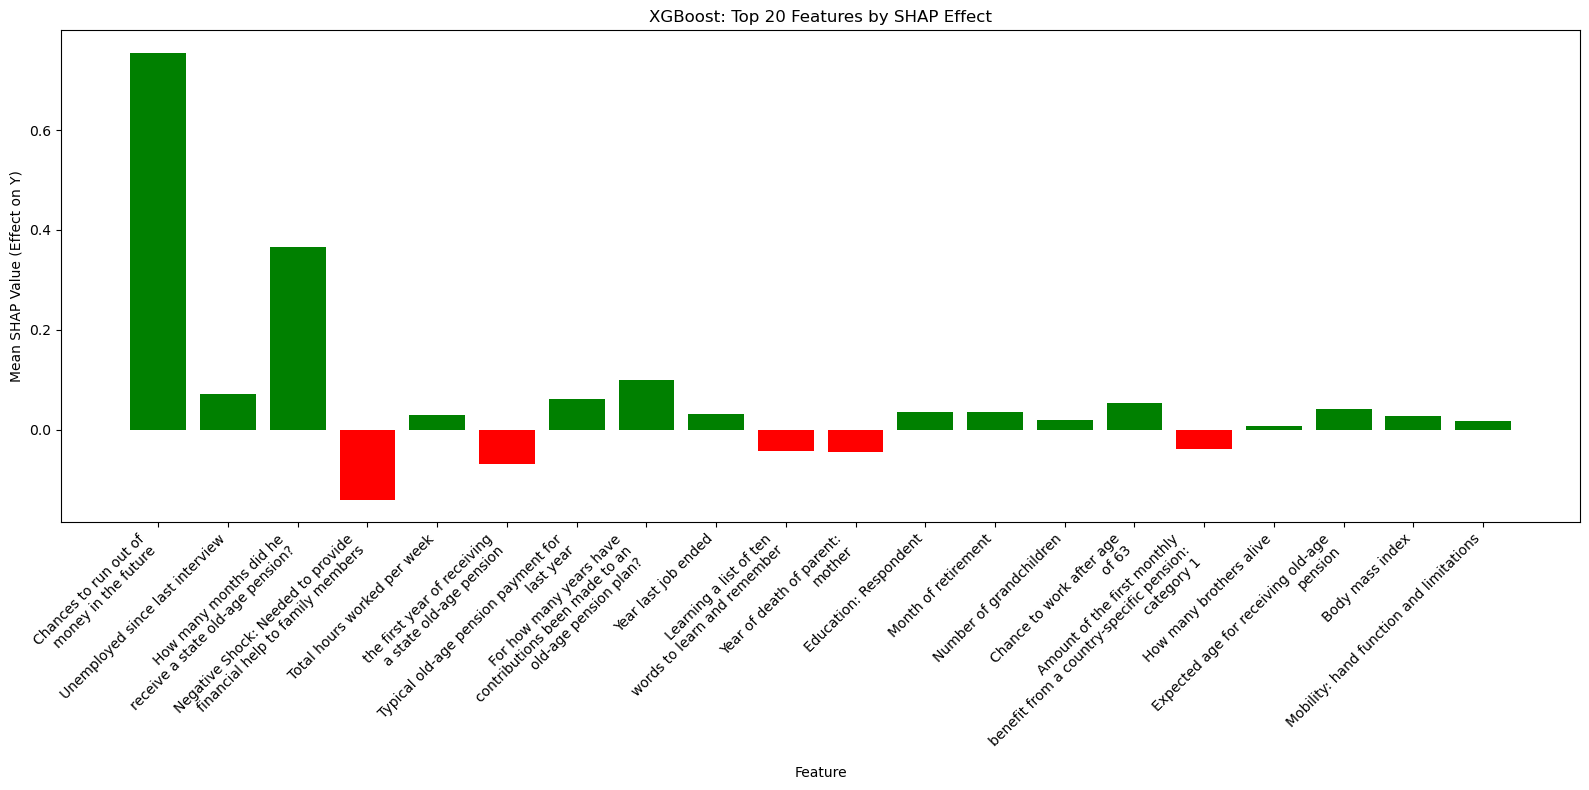


Top 20 SHAP features by mean effect:

Chances to run out of money in the future: Mean SHAP Value 0.7550
Unemployed since last interview: Mean SHAP Value 0.0716
How many months did he receive a state old-age pension?: Mean SHAP Value 0.3660
Negative Shock: Needed to provide financial help to family members: Mean SHAP Value -0.1407
Total hours worked per week: Mean SHAP Value 0.0291
the first year of receiving a state old-age pension: Mean SHAP Value -0.0699
Typical old-age pension payment for last year: Mean SHAP Value 0.0620
For how many years have contributions been made to an old-age pension plan?: Mean SHAP Value 0.0988
Year last job ended: Mean SHAP Value 0.0315
Learning a list of ten words to learn and remember: Mean SHAP Value -0.0436
Year of death of parent: mother: Mean SHAP Value -0.0447
Education: Respondent: Mean SHAP Value 0.0345
Month of retirement: Mean SHAP Value 0.0343
Number of grandchildren: Mean SHAP Value 0.0199
Chance to work after age of 63: Mean SHAP Value 0.052

In [105]:
"""
Compute SHAP values for the model, summarize and rank feature effects, and visualize the top 30 features by their SHAP impact.
"""

# Generate SHAP values for test data
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Calculate mean SHAP value and absolute mean SHAP for each feature
shap_vals = shap_values.values
feature_names = X_train.columns

mean_shap = np.mean(shap_vals, axis=0)
abs_mean_shap = np.mean(np.abs(shap_vals), axis=0)

# Number of top features to display
top_n = 20  # Use 20 for readability, or 30 if needed

# Create a DataFrame with feature SHAP values, sorted by importance
df_shap = pd.DataFrame({
    'feature': feature_names,
    'mean_shap': mean_shap,
    'abs_mean_shap': abs_mean_shap
})
df_shap = df_shap.sort_values('abs_mean_shap', ascending=False).head(top_n)

# Prepare labels (wrap long labels to 5 words per line)
labels = [wrap_label_words(get_feature_label(f), words_per_line=5) for f in df_shap['feature']]

plt.figure(figsize=(max(14, top_n * 0.8), 8))
colors = df_shap['mean_shap'].apply(lambda x: 'green' if x > 0 else 'red')

plt.bar(range(top_n), df_shap['mean_shap'], color=colors)
plt.xticks(range(top_n), labels, rotation=45, ha='right', fontsize=10)
plt.title('XGBoost: Top {} Features by SHAP Effect'.format(top_n))
plt.ylabel('Mean SHAP Value (Effect on Y)')
plt.xlabel('Feature')
plt.tight_layout()

plt.savefig("02_xgboost_shap_effects.png", bbox_inches='tight', dpi=200)
plt.show()

print(f"\nTop {top_n} SHAP features by mean effect:")
print()

for f, v in zip(df_shap['feature'], df_shap['mean_shap']):
    print(f"{get_feature_label(f)}: Mean SHAP Value {v:.4f}")


In [107]:
"""
Ordinary Least Squares (OLS) regression with log-transformed target.

- The target variable (age2020) is log-transformed to stabilize variance and improve linearity.
- The initial OLS model is fitted with all standardized features.
- Only statistically significant features (p < 0.05) are selected for further modeling.
- For additional precision, features with high multicollinearity (Variance Inflation Factor, VIF > 5) are removed.
- The final OLS model is fitted with only significant and non-collinear features.

This approach ensures an interpretable linear model where each included feature is both statistically significant and not highly collinear with the others.
"""

# Log-transform the target
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# OLS with all features (before significance filtering)
X_train_std.index = y_train.index
X_train_std_sm = sm.add_constant(X_train_std)
ols_sm = sm.OLS(y_train_log, X_train_std_sm)
results = ols_sm.fit()

# Select statistically significant features (p < 0.05, exclude Intercept)
coefs = results.params
pvals = results.pvalues
features_sm = ['Intercept'] + list(X_train.columns)
significant_mask = (pvals < 0.05) & (np.array(features_sm) != 'Intercept')
significant_features = np.array(features_sm)[significant_mask]
significant_coefs = coefs[significant_mask]

# Subset only significant features
X_train_sign = X_train_std[significant_features]

# Remove features with high VIF (VIF > 5)
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif_df = calculate_vif(X_train_sign)
to_drop = vif_df[vif_df["VIF"] > 5]["variables"]
X_train_sign = X_train_sign.drop(columns=to_drop)

# Synchronize test set columns
X_test_sign = X_test_std[X_train_sign.columns]

# Add intercept term
X_train_sign_sm = sm.add_constant(X_train_sign)
X_test_sign_sm = sm.add_constant(X_test_sign)

# Fit final OLS model on significant, non-collinear features
ols_sm_sign = sm.OLS(y_train_log, X_train_sign_sm)
results_sign = ols_sm_sign.fit()


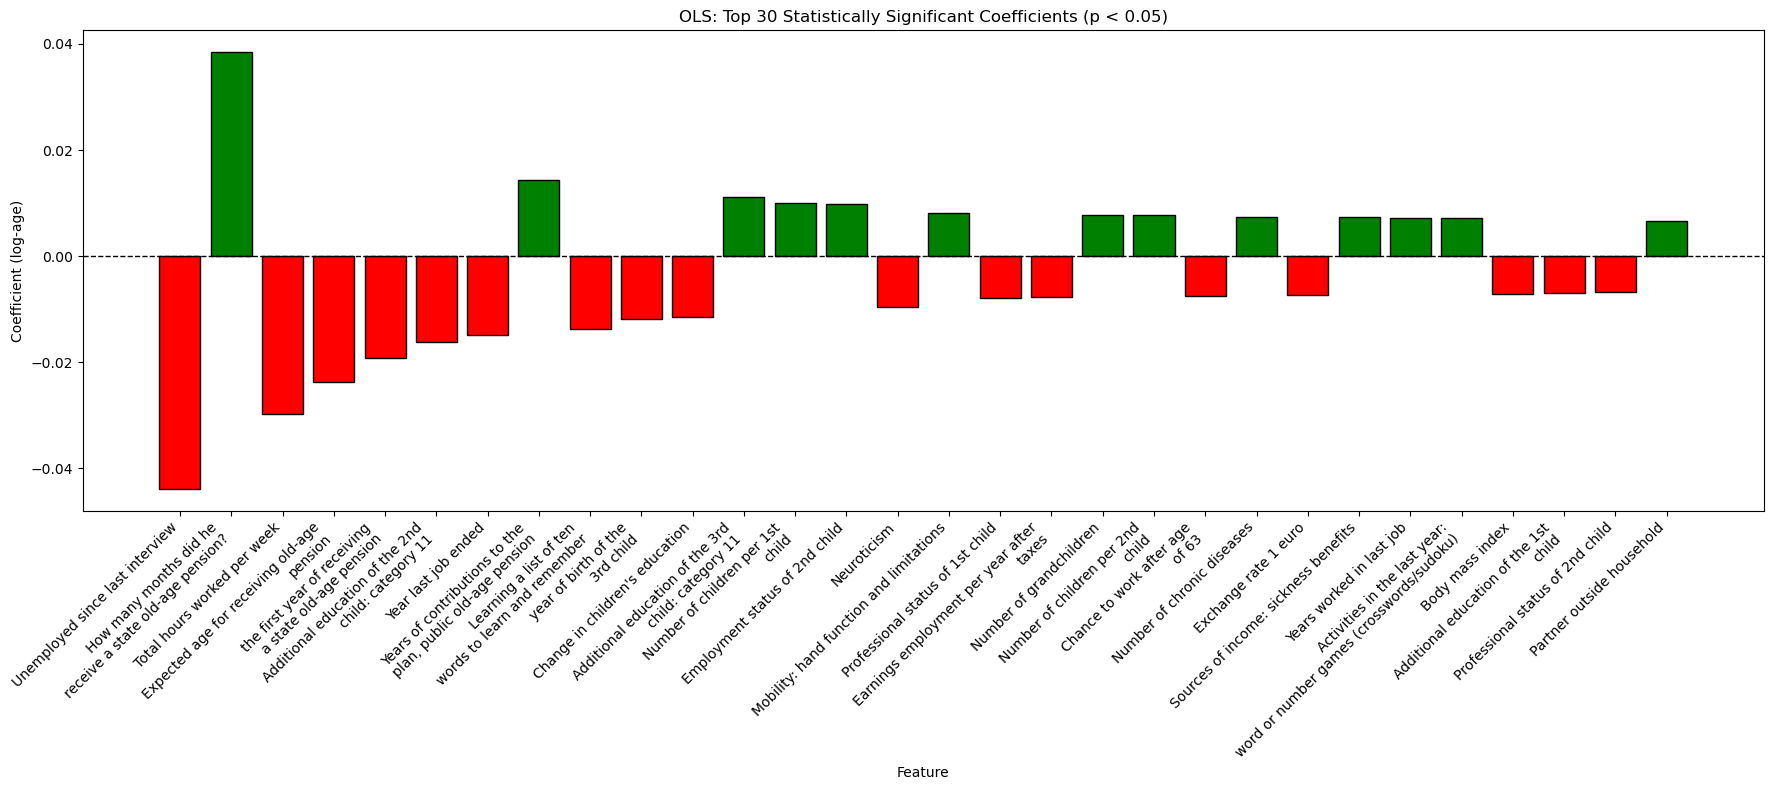

                            OLS Regression Results                            
Dep. Variable:                age2020   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     969.8
Date:                Sat, 28 Jun 2025   Prob (F-statistic):               0.00
Time:                        21:25:13   Log-Likelihood:                 44833.
No. Observations:               37386   AIC:                        -8.948e+04
Df Residuals:                   37294   BIC:                        -8.870e+04
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [31]:
"""
Show and visualize the top 30 statistically significant OLS coefficients by absolute value, with color indicating direction; print OLS model summary.
"""

top_n = 30
idx_top = np.argsort(np.abs(significant_coefs))[::-1][:top_n]
top_features = np.array(significant_features)[idx_top]
top_coefs = significant_coefs.iloc[idx_top]

plt.figure(figsize=(max(16, top_n * 0.6), 8))
colors = ['green' if c > 0 else 'red' for c in top_coefs]

# Wrap feature labels (5 words per line)
labels = [wrap_label_words(get_feature_label(f), words_per_line=5) for f in top_features]

plt.bar(range(top_n), top_coefs, color=colors, edgecolor='black')
plt.xticks(range(top_n), labels, rotation=45, ha='right', fontsize=10)
plt.ylabel("Coefficient (log-age)")
plt.xlabel("Feature")
plt.title("OLS: Top 30 Statistically Significant Coefficients (p < 0.05)")
plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
plt.tight_layout()

plt.savefig("03_ols_significant_coefficients.png", bbox_inches='tight', dpi=200)
plt.show()

print(results_sign.summary())


In [109]:
"""
Predict and evaluate the final Ordinary Least Squares (OLS) model (with significant features) on the test and train sets using the following metrics:
- Coefficient of Determination (R^2)
- Adjusted R-squared (Adjusted R^2)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)
- Mean Squared Error (MSE)
"""

# Predict for test set
y_pred_test_log_sign = results_sign.predict(X_test_sign_sm)
y_pred_test_sign = np.exp(y_pred_test_log_sign)

# Predict for train set
X_train_sign_sm = sm.add_constant(X_train_sign, has_constant='add')
y_pred_train_log_sign = results_sign.predict(X_train_sign_sm)
y_pred_train_sign = np.exp(y_pred_train_log_sign)

# Test metrics
print(f"\nTEST set R^2: {r2_score(y_test, y_pred_test_sign):.3f}")
print(f"TEST set MAE: {mean_absolute_error(y_test, y_pred_test_sign):.3f}")
print(f"TEST set MAPE: {mape(y_test, y_pred_test_sign):.2f}%")
print(f"TEST set MSE: {mean_squared_error(y_test, y_pred_test_sign):.3f}")
n_test = X_test.shape[0]
p_test = X_test_sign.shape[1]
adj_r2_test = 1 - (1 - r2_score(y_test, y_pred_test_sign)) * (n_test - 1) / (n_test - p_test - 1)
print(f"TEST set Adjusted R^2: {adj_r2_test:.3f}")

# Train metrics
print(f"\nTRAIN set R^2: {r2_score(y_train, y_pred_train_sign):.3f}")
print(f"TRAIN set MAE: {mean_absolute_error(y_train, y_pred_train_sign):.3f}")
print(f"TRAIN set MAPE: {mape(y_train, y_pred_train_sign):.2f}%")
print(f"TRAIN set MSE: {mean_squared_error(y_train, y_pred_train_sign):.3f}")
n_train = X_train.shape[0]
p_train = X_train_sign.shape[1]
adj_r2_train = 1 - (1 - r2_score(y_train, y_pred_train_sign)) * (n_train - 1) / (n_train - p_train - 1)
print(f"TRAIN set Adjusted R^2: {adj_r2_train:.3f}")



TEST set R^2: 0.708
TEST set MAE: 3.916
TEST set MAPE: 13.25%
TEST set MSE: 25.989
TEST set Adjusted R^2: 0.706

TRAIN set R^2: 0.711
TRAIN set MAE: 3.921
TRAIN set MAPE: 5.60%
TRAIN set MSE: 26.027
TRAIN set Adjusted R^2: 0.710


In [111]:
    """
    Create and export a summary table of all statistically significant OLS features, including sign and effect direction.
    """
    
    summary_df = pd.DataFrame({
        "Feature": [get_feature_label(f) for f in significant_features],
        "Coefficient (log-age)": significant_coefs.values,
        "Significance (p < 0.05)": ["Yes"] * len(significant_features),
        "Effect": ["Positive" if coef > 0 else "Negative" for coef in significant_coefs]
    })
    summary_df = summary_df.reindex(np.abs(summary_df["Coefficient (log-age)"]).sort_values(ascending=False).index)
    
    print("\nAll statistically significant features from the log-OLS model:\n")
    print(summary_df.to_string(index=False))
    
    # Export summary to Excel
    # summary_df.to_excel("significant_features_summary.xlsx", index=False)
    # print("The summary table of significant features has been saved as significant_features_summary.xlsx")



All statistically significant features from the log-OLS model:

                                                                        Feature  Coefficient (log-age) Significance (p < 0.05)   Effect
                                                Unemployed since last interview              -0.043913                     Yes Negative
                        How many months did he receive a state old-age pension?               0.038458                     Yes Positive
                                                    Total hours worked per week              -0.029871                     Yes Negative
                                     Expected age for receiving old-age pension              -0.023792                     Yes Negative
                            the first year of receiving a state old-age pension              -0.019206                     Yes Negative
                             Additional education of the 2nd child: category 11              -0.016262                 

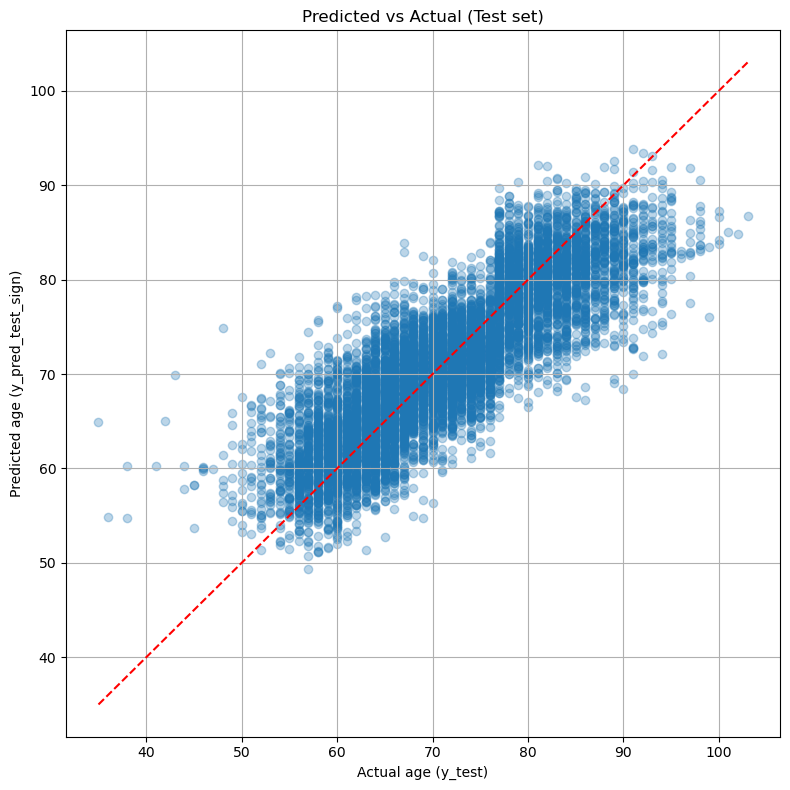

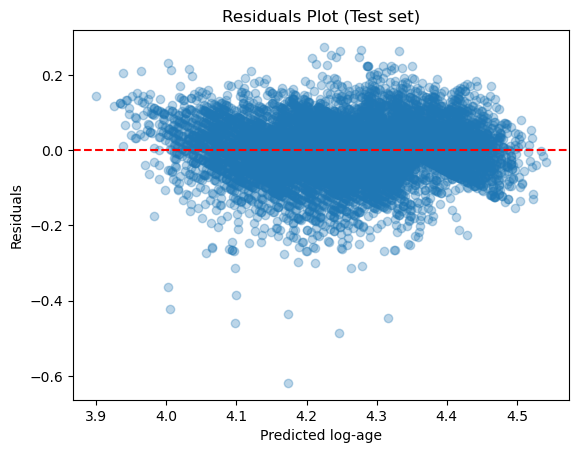

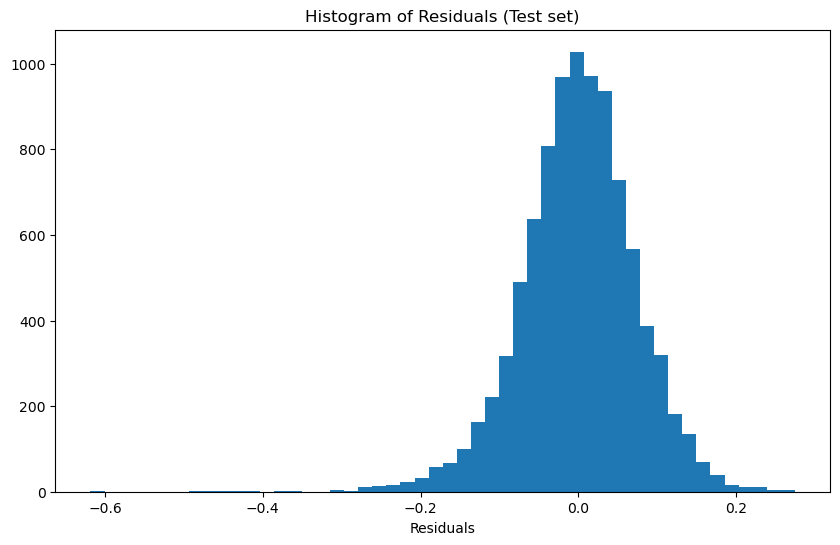

In [113]:
"""
Visualize model performance on the test set: predicted vs. actual scatter, residuals plot, and histogram of residuals.
"""

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred_test_sign, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual age (y_test)")
plt.ylabel("Predicted age (y_pred_test_sign)")
plt.title("Predicted vs Actual (Test set)")
plt.grid(True)
plt.tight_layout()
plt.show()

residuals = y_test_log.values - y_pred_test_log_sign
plt.scatter(y_pred_test_log_sign, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log-age")
plt.ylabel("Residuals")
plt.title("Residuals Plot (Test set)")
plt.show()

plt.figure(figsize=(10,6))
plt.hist(residuals, bins=50)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals (Test set)")
plt.show()



Features with linear relationship to age2020:

                 Feature  Intercept  Coefficient       p-value          R^2
                 ep106_1  71.209517    -4.885372  0.000000e+00 2.652744e-01
                 ep208_1  71.209517     4.671929  0.000000e+00 2.426010e-01
                  ep013_  71.209517    -4.572960  0.000000e+00 2.324315e-01
                 ep103_1  71.209517    -4.392833  0.000000e+00 2.144813e-01
                cf016tot  71.209517    -3.581082  0.000000e+00 1.425373e-01
                  ep205e  71.209517    -3.433356  0.000000e+00 1.310201e-01
                ep078e_1  71.209517     3.140349  0.000000e+00 1.096115e-01
                mobility  71.209517     3.013811  0.000000e+00 1.009560e-01
                 maxgrip  71.209517    -2.962218  0.000000e+00 9.752907e-02
                ep609e_1  71.209517    -2.795300  0.000000e+00 8.684742e-02
                  ch511_  71.209517    -2.680975  0.000000e+00 7.988876e-02
              chronicw8c  71.209517     

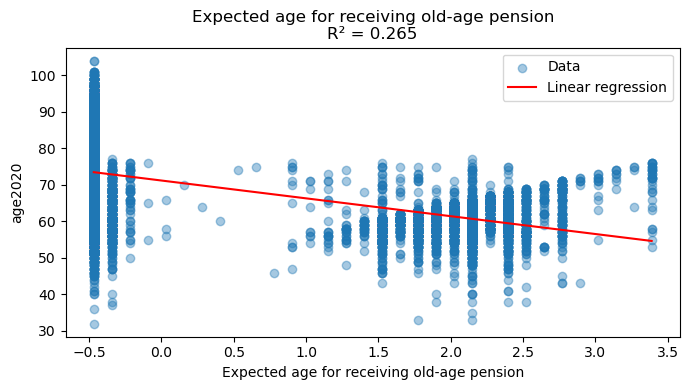

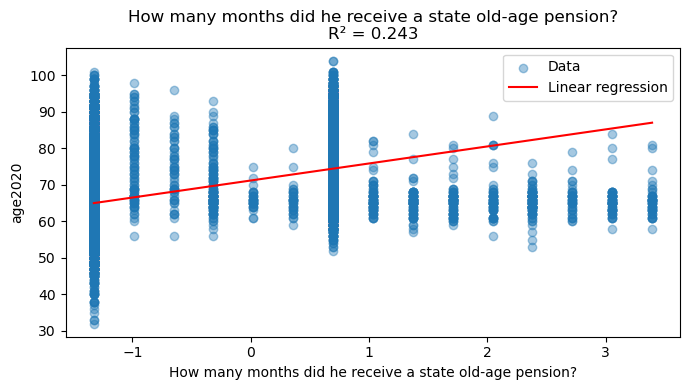

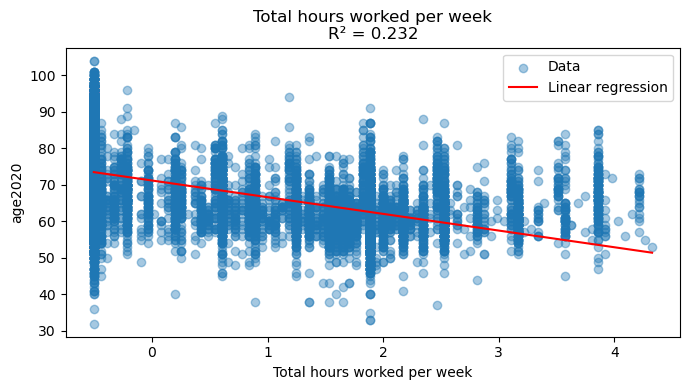

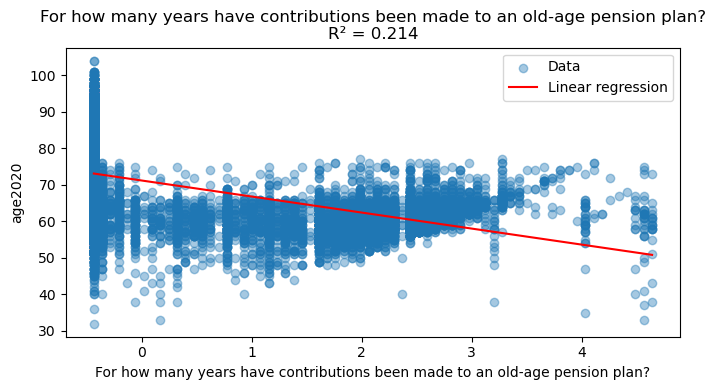

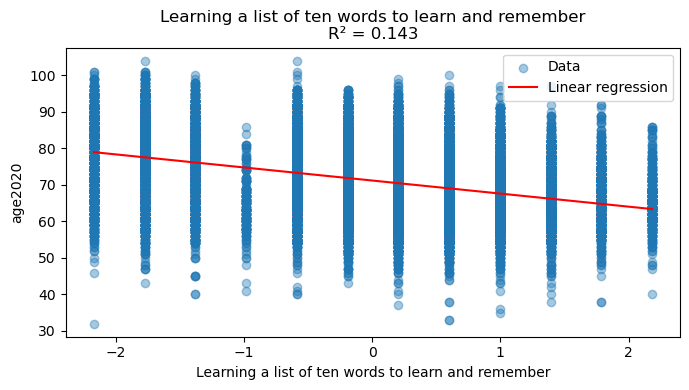

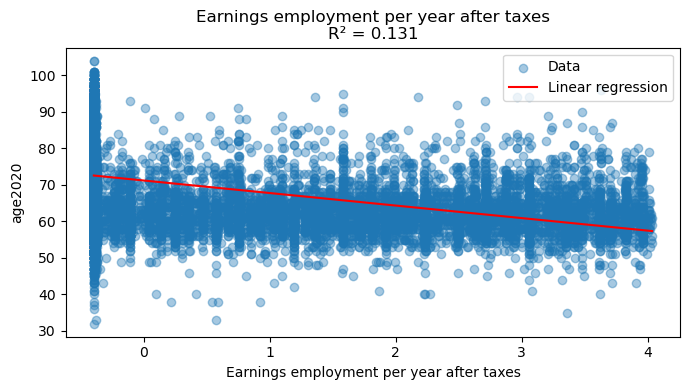

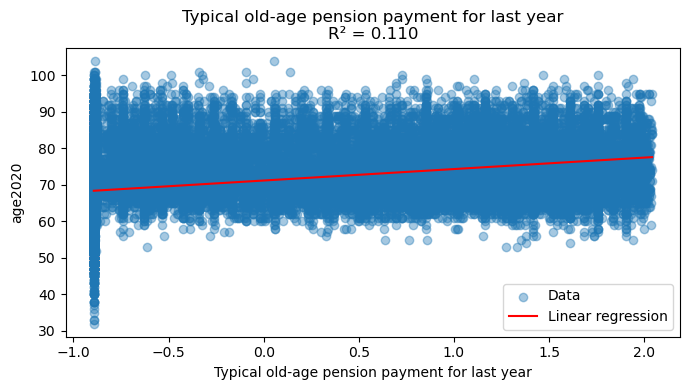

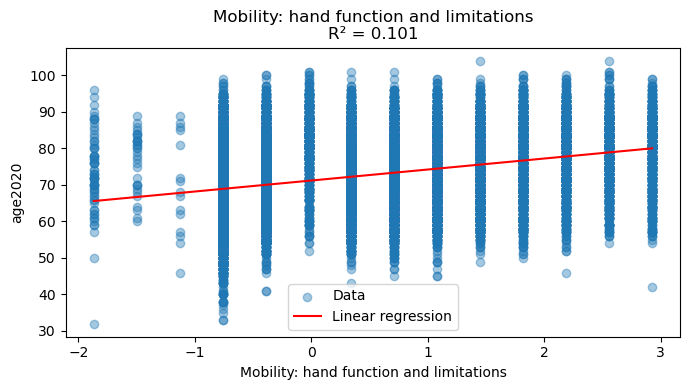

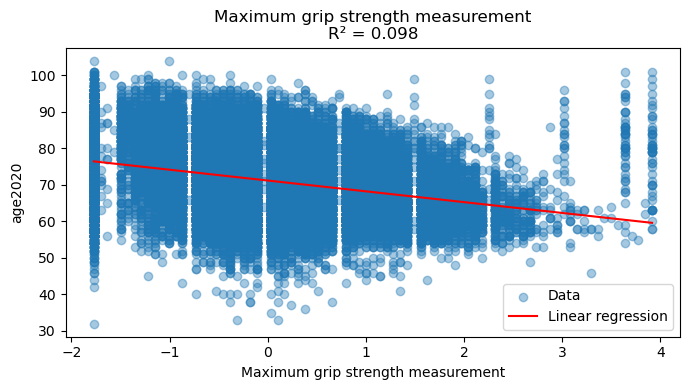

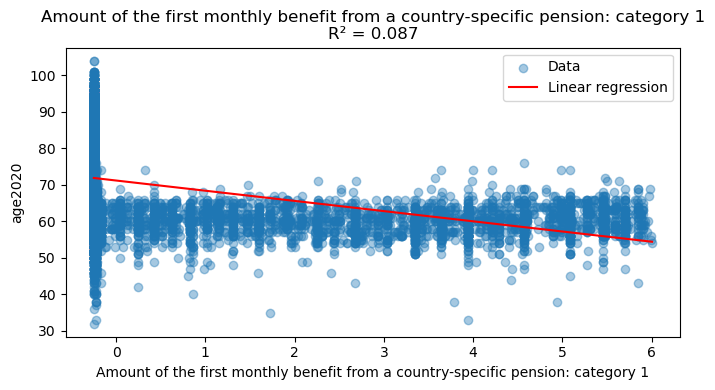

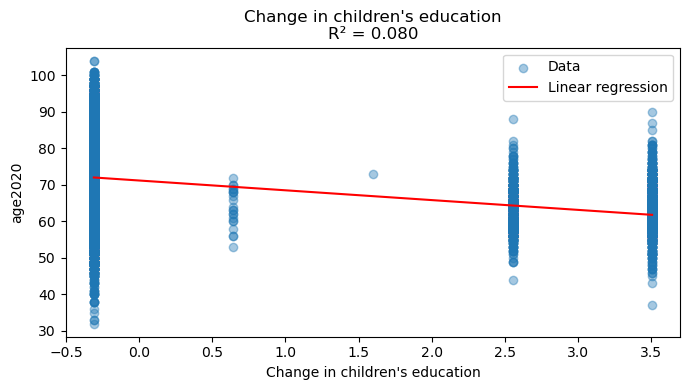

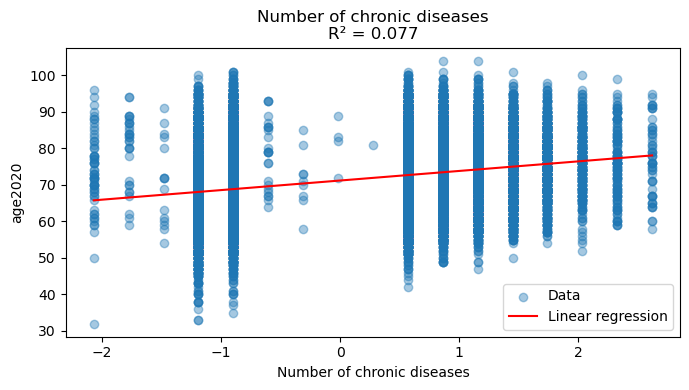

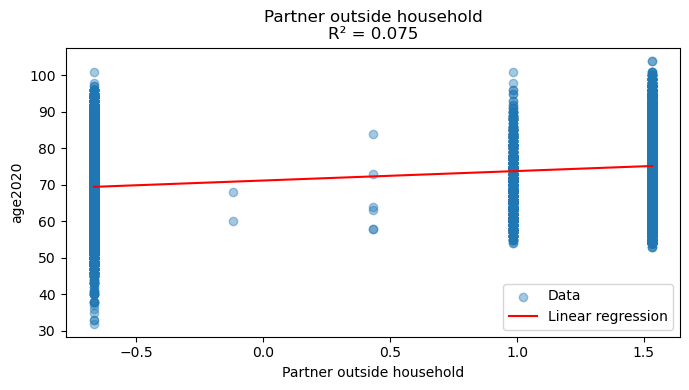

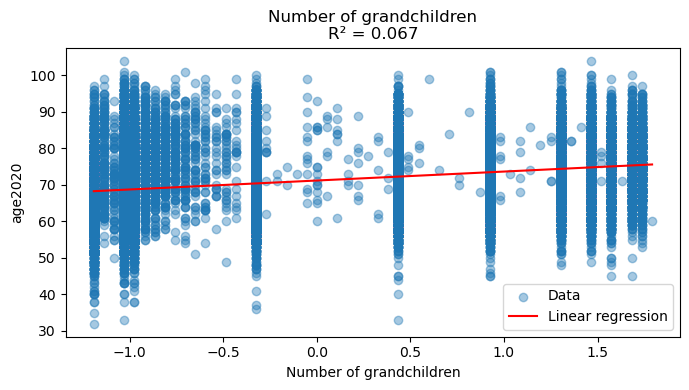

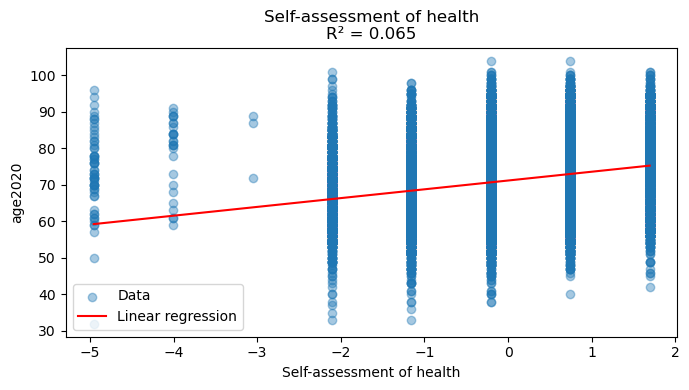

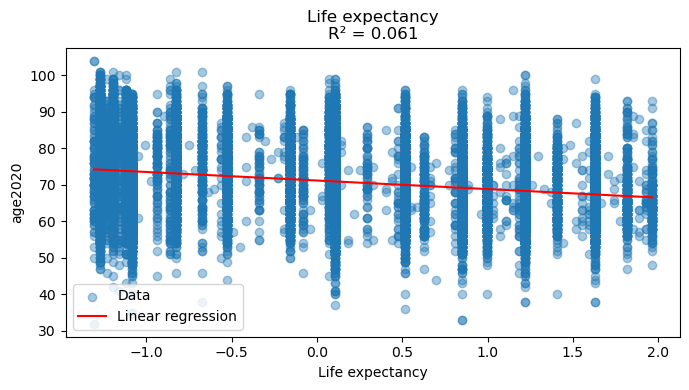

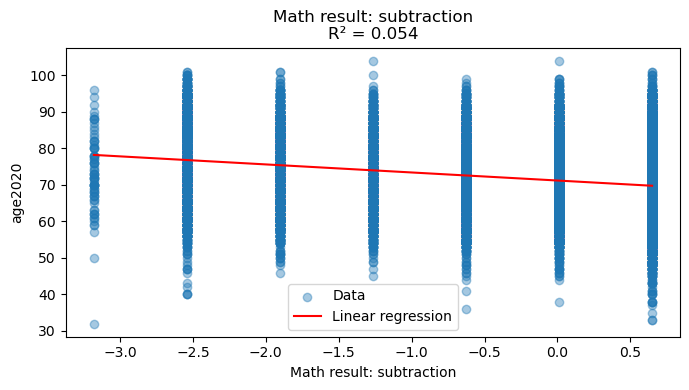

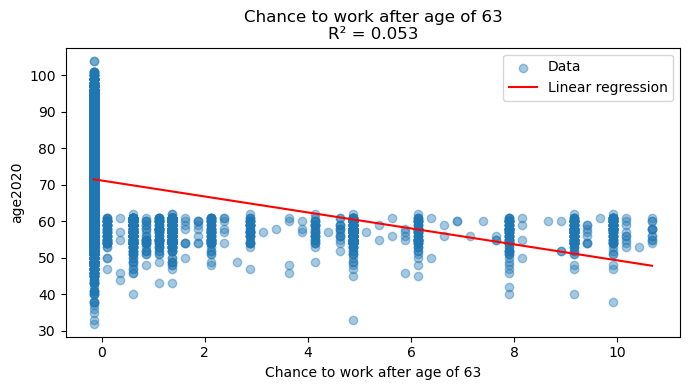

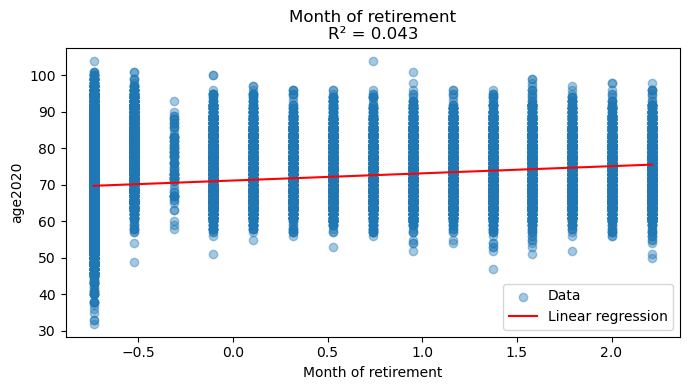

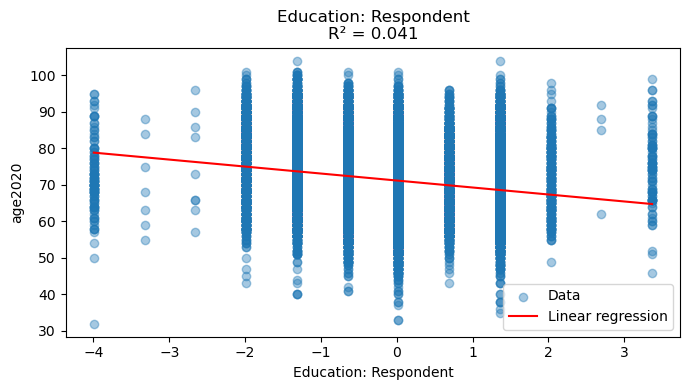

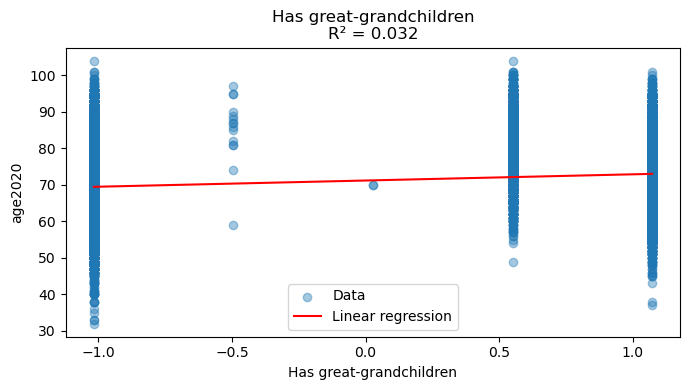

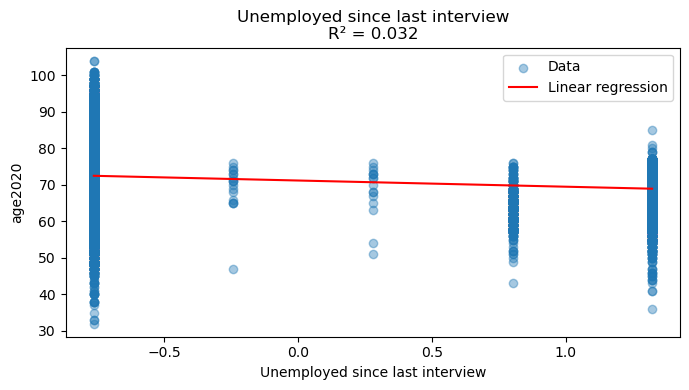

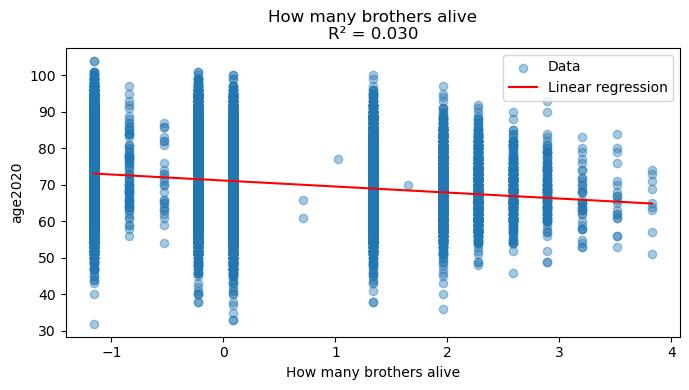

In [119]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Синхронизация на индексите (за всеки случай)
common_idx = X_train_sign.index.intersection(y_train.index)
X_train_sign = X_train_sign.loc[common_idx]
y_train = y_train.loc[common_idx]

selected_features = []
results_table = []

# Изчисляване на едновариантни регресии за всеки фийчър
for col in X_train_sign.columns:
    X_feat = X_train_sign[[col]]
    X_feat_const = sm.add_constant(X_feat)
    y = y_train

    model = sm.OLS(y, X_feat_const).fit()
    coef = model.params[col]
    intercept = model.params['const']
    pval = model.pvalues[col]
    r2 = model.rsquared

    selected_features.append(col)
    results_table.append({
        "Feature": col,
        "Intercept": intercept,
        "Coefficient": coef,
        "p-value": pval,
        "R^2": r2
    })

# Резултати като DataFrame, сортирани по R²
results_df = pd.DataFrame(results_table)
results_df = results_df.sort_values(by="R^2", ascending=False)
print("\nFeatures with linear relationship to age2020:\n")
print(results_df.to_string(index=False))

# Филтър: ВСИЧКИ features с R² ≥ 0.03
filtered_df = results_df[results_df["R^2"] >= 0.03]
print(f"\nОбщо {len(filtered_df)} features с R² ≥ 0.03")

# Визуализация за ВСЕКИ от тях
for _, row in filtered_df.iterrows():
    feature = row["Feature"]
    r2 = row["R^2"]
    X_feat = X_train_sign[[feature]]
    X_feat_const = sm.add_constant(X_feat)
    y = y_train

    model = sm.OLS(y, X_feat_const).fit()

    plt.figure(figsize=(7, 4))
    plt.scatter(X_feat[feature], y, alpha=0.4, label='Data')
    y_pred = model.predict(X_feat_const)
    sort_idx = np.argsort(X_feat[feature].values.flatten())
    plt.plot(X_feat[feature].values[sort_idx], y_pred.values[sort_idx], color='red', label='Linear regression')

    plt.xlabel(feature)
    plt.ylabel('age2020')
    plt.title(f'{feature}\nR² = {r2:.3f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
